# Importing Needed Libraries

In [2]:
import numpy as np

from tensorflow import keras

import tensorflow as tf

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

# Loading Preprocessed Data

In [4]:
X_train = []
X_test = []

X_train.append(np.load('npys/train_features.npy'))
X_train.append(np.load('npys/train_masks.npy'))
y_train = np.load('npys/train_labels.npy')

X_test.append(np.load('npys/test_features.npy'))
X_test.append(np.load('npys/test_masks.npy'))
y_test = np.load('npys/test_labels.npy')

In [6]:
label_types = ['Lateral-raise', 'bensh-press', 'bicep-curls', 'cable-flies', 'dips', 'handstand-push-ups', 'lat-pulldown', 'leg-press', 'pull-ups', 'push-ups', 'sit-ups', 'squats']

label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique( label_types))

c:\Users\aminb\anaconda3\Lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [7]:
print(f"Frame features in train set: {X_train[0].shape}")
print(f"Frame masks in train set: {X_train[1].shape}")



print(f"train_labels in train set: { y_train.shape}")

print(f"test_labels in train set: { y_test.shape}")


Frame features in train set: (747, 20, 2048)
Frame masks in train set: (747, 20)
train_labels in train set: (747, 1)
test_labels in train set: (187, 1)


# Building and Training the Model

In [24]:


def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.LSTM( 32, stateful=False, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU( 8)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"]
    )
    return rnn_model



def run_experiment():
    
    from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

    model_save = ModelCheckpoint( 'models/best_model_2_12.keras',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose= 1)
    
    rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.1,
                            patience=5,
                            verbose=0,
                            mode="max",
                            min_delta=0.001)
    
    es = EarlyStopping(monitor='val_loss', 
                                    patience=6, 
                                    restore_best_weights=True)

    seq_model = get_sequence_model()
    #seq_model.load_weights( 'models/best_model_30_11.keras')
    
    history = seq_model.fit(
        [X_train[0], X_train[1]],
        y_train,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[ model_save, es, rlr],
    )

    #seq_model.load_weights(filepath)
    #_, accuracy = seq_model.evaluate([ X_test, X_test], y_test)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history,sequence_model = run_experiment()

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 2.4891 - accuracy: 0.0938
Epoch 1: val_loss improved from inf to 2.45019, saving model to models\best_model_2_12.keras
19/19 [==============================] - 6s 102ms/step - loss: 2.4891 - accuracy: 0.0938 - val_loss: 2.4502 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 2.4160 - accuracy: 0.1591
Epoch 2: val_loss improved from 2.45019 to 2.37342, saving model to models\best_model_2_12.keras
19/19 [==============================] - 1s 42ms/step - loss: 2.4160 - accuracy: 0.1591 - val_loss: 2.3734 - val_accuracy: 0.1533 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 2.3454 - accuracy: 0.1993
Epoch 3: val_loss improved from 2.37342 to 2.34522, saving model to models\best_model_2_12.keras
19/19 [==============================] - 1s 46ms/step - loss: 2.3454 - accuracy: 0.1993 - val_loss: 2.3452 - val_accuracy: 0.2000 - lr: 0.001

# Visualising Model Training History

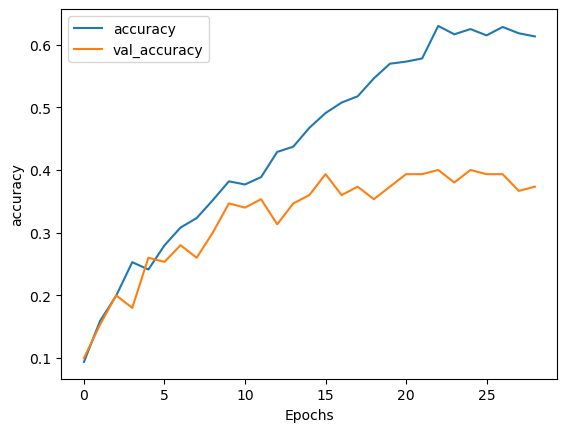

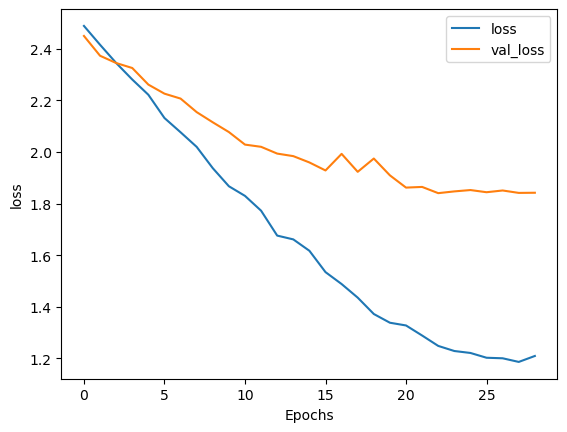

In [25]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and loss
plot_graphs( history, "accuracy")
plot_graphs( history, "loss")

# Computing Test Accuracy

In [28]:
sequence_model.evaluate( [ X_test[0], X_test[1]], y_test)

6/6 [==============================] - 0s 12ms/step - loss: 1.9212 - accuracy: 0.3797


[1.92121422290802, 0.3796791434288025]